In [54]:
# Carregando alguns módulos essenciais para trabalharmos os dados
# Removendo warnings chatos
#! pip install catboost
#! pip install lightgbm
#! pip install xgboost

import warnings
warnings.filterwarnings('ignore')

# Carregando as principais bibliotecas com o 'import'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import List, Tuple

# Stats libs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os

# Modelling libs
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,AdaBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, DMatrix, cv
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature importance
from sklearn.inspection import permutation_importance

# Categorical encoders
from category_encoders.target_encoder import TargetEncoder

from matplotlib.dates import DateFormatter

sns.set(font_scale=1.2, style="whitegrid")

# Algumas opções do Pandas boas para vermos muitas linhas e colunas de uma vez
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999 

# Carregando os dados
df = pd.read_csv('fraud_detection_dataset.csv')

In [55]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Função para calcular o VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

#Função para criar Datasets de Treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Splits dataframe in training, testing and validation sets"""

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

In [56]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [58]:
# Aplicando o .describe(), lembrando que ele irá considerar apenas dados numéricos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [59]:
#Fazendo uma contagem de do conteúdo de fraude e não fraude
pd.DataFrame(df.isFlaggedFraud.value_counts().values, index=['Não é fraude','É fraude, transferiu mais 200.000'], columns=['Quantidade'], )

,Quantidade
Não é fraude,6362604
"É fraude, transferiu mais 200.000",16


In [60]:
pd.DataFrame(df.isFraud.value_counts().values, index=['Não é fraude','É Fraude'], columns=['Quantidade'], )

,Quantidade
Não é fraude,6354407
É Fraude,8213


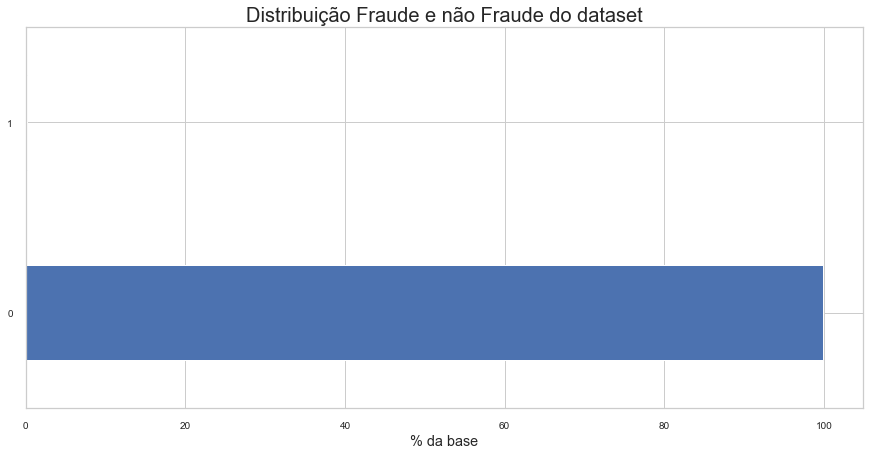

In [61]:
# Vamos usar a função de plot do próprio Dataframe, multiplicando por 100 para interpretarmos como percentual
plt.figure(figsize=(15,7))
(df.isFraud.value_counts(normalize=True)*100).plot(kind='barh')
plt.title('Distribuição Fraude e não Fraude do dataset',size=20)
plt.xlabel("% da base")
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()

In [62]:
# Variavel de interesse
target = 'isFraud'
print('target:', target)

# Variaveis numericas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove(target)
print(f'numerical vars({len(num_vars)}): {num_vars}')

# Variaveis categorical
cat_vars = df.select_dtypes(exclude=['int', 'float']).columns.tolist()

print(f'categorical vars({len(cat_vars)}): {cat_vars}')

target: isFraud
numerical vars(7): ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
categorical vars(3): ['type', 'nameOrig', 'nameDest']


In [63]:
#Analisando valores nulos para cada variavel
df.isnull().mean()

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

Text(0.0, 1.0, 'Correlação das variáveis numéricas')

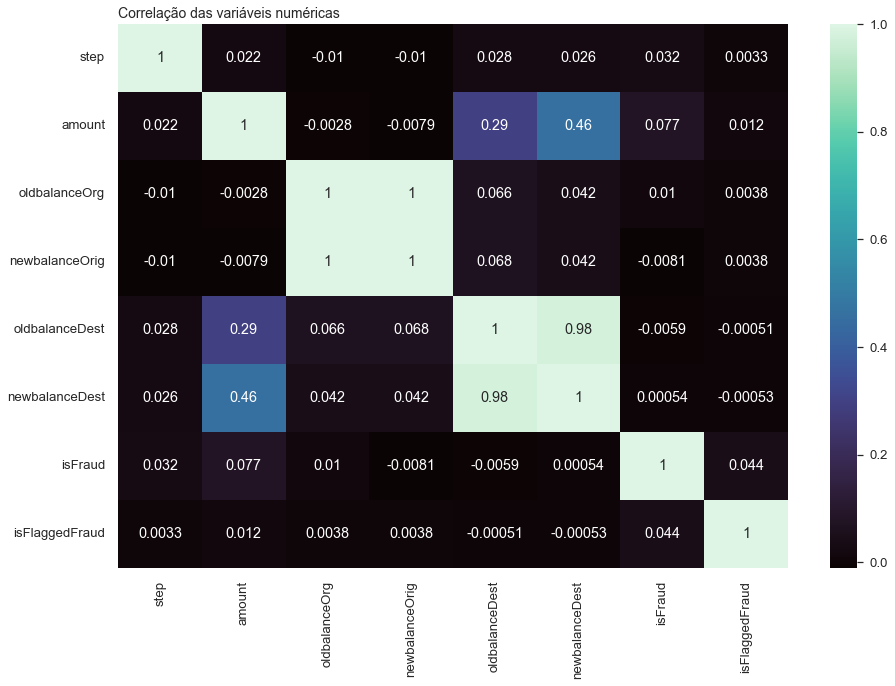

In [64]:
#Correlação entre os features mais importantes para a classificação
plt.figure(figsize=(15,10))
ax = sns.heatmap(df.corr(), annot=True, cmap = 'mako')
plt.title('Correlação das variáveis numéricas', fontsize = 14, loc = 'left')

In [65]:
corr_matrix = df[num_vars + [target]].corr()
corr_matrix[target].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [66]:
# criar feature engineering - nova variavel a partir da  subtração " oldbalanceDest - newbalancedest'"
#Vamos criar feature engineering considerando a quantidade de transações de cada name de origem e destino. Depois 
#faremos um índice
dic_origem = {}
for index, valor in zip(df.nameOrig.value_counts().index, df.nameOrig.value_counts().values):
    dic_origem[index] = valor
dic_destino = {}
for index, valor in zip(df.nameDest.value_counts().index, df.nameDest.value_counts().values):
    dic_destino[index] = valor

df['quantorigem'] = df.nameOrig.map(dic_origem)
df['quantdestino'] = df.nameDest.map(dic_destino)
df['amuntDest'] = df['oldbalanceDest']- df['newbalanceDest']

In [67]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,quantorigem,quantdestino,amuntDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,1,1,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,1,1,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,1,44,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,1,41,21182.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,1,1,0.00
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,1,1,0.00
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,1,1,0.00
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,1,1,0.00
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,1,1,0.00
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,1,34,1549.21


Text(0.0, 1.0, 'Correlação das variáveis numéricas')

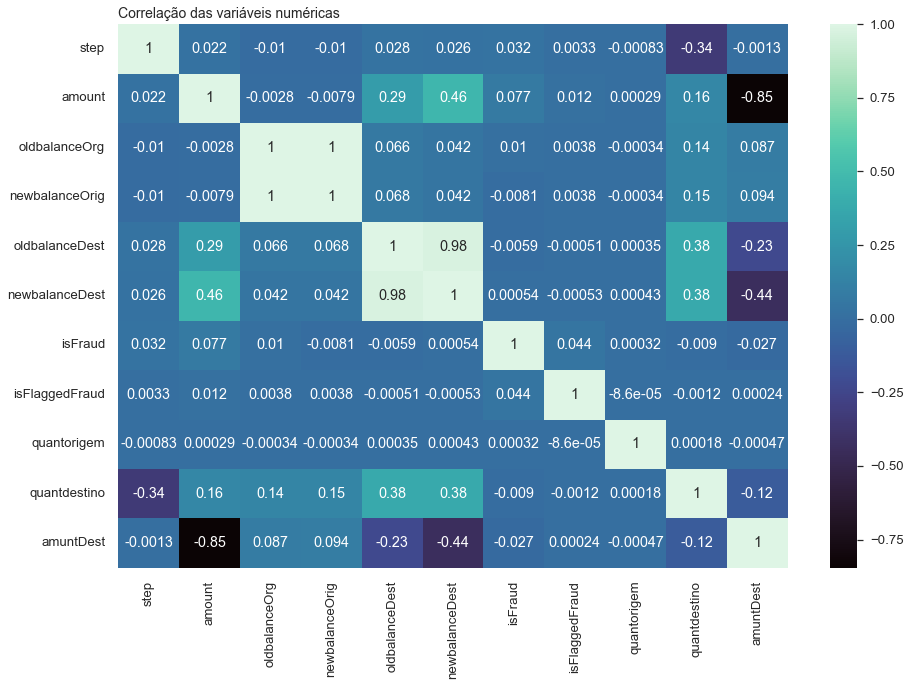

In [68]:
#Correlação entre os features mais importantes para a classificação
plt.figure(figsize=(15,10))
ax = sns.heatmap(df.corr(), annot=True, cmap = 'mako')
plt.title('Correlação das variáveis numéricas', fontsize = 14, loc = 'left')

In [69]:
corr_matrix[target].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [70]:
#selecionando novamente as variáveis
# Features numericas
num_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
print(f'numerical features({len(num_features)}): {num_features}')

# Features categoricas
cat_features = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
df[cat_features] = df[cat_features].astype("category")
print(f'categorical features({len(cat_features)}): {cat_features}')


numerical features(11): ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'quantorigem', 'quantdestino', 'amuntDest']
categorical features(3): ['type', 'nameOrig', 'nameDest']


In [82]:
# Separando as features e as variáveis de interesse
# Separando as features e as variáveis de interesse
# As variáveis: oldbalanceorg, newbalanceorig, oldbalancedest e newbalancedest possuem valores de VIF muito elevados, indicando que as variáveis estão altamente correlacionadas.
# Isso significa que se usarmos essas variáveis no modelo teremos uma alta multicolinearidade. vamos tirá-las
X = df.drop(['isFraud','oldbalanceDest','newbalanceOrig' ],axis=1)
y = df.isFraud

#X = df.drop(['isFraud'],axis=1)
#y = df.isFraud


In [83]:
# Pré-processamento das variáveis categóricas (categorical encoders)
X[cat_features] = TargetEncoder().fit_transform(X[cat_features], y)
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,nameDest,newbalanceDest,isFlaggedFraud,quantorigem,quantdestino,amuntDest
0,1,0.000000,9839.64,0.001291,170136.0,0.001291,0.0,0,1,1,0.0
1,1,0.000000,1864.28,0.001291,21249.0,0.001291,0.0,0,1,1,0.0
2,1,0.007688,181.00,0.001291,181.0,0.022727,0.0,0,1,44,0.0
3,1,0.001840,181.00,0.001291,181.0,0.024390,0.0,0,1,41,21182.0
4,1,0.000000,11668.14,0.001291,41554.0,0.001291,0.0,0,1,1,0.0


Text(0.0, 1.0, 'Correlação das variáveis numéricas')

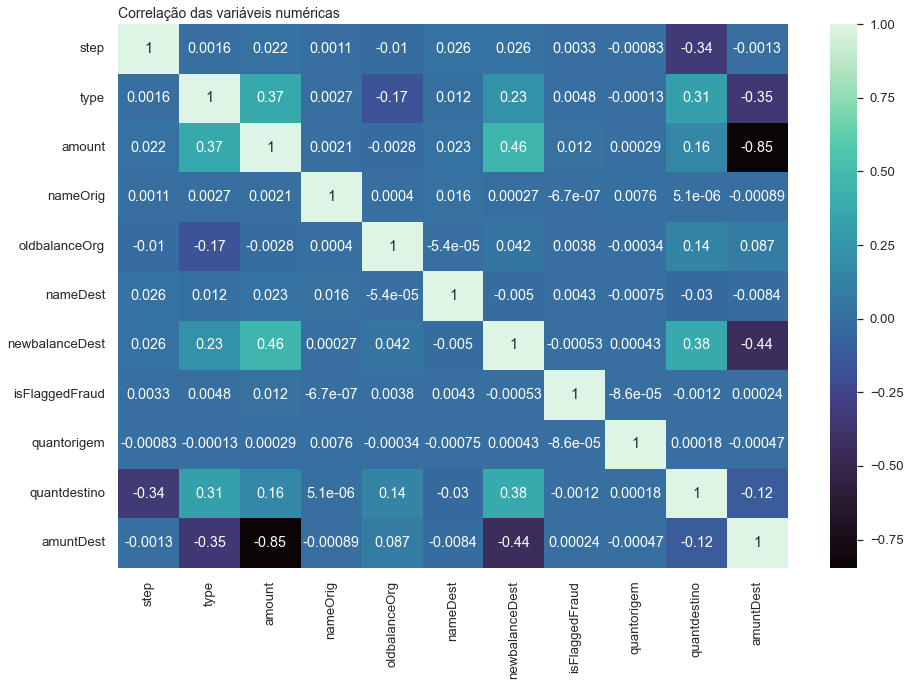

In [84]:
#Correlação entre os features mais importantes para a classificação
plt.figure(figsize=(15,10))
ax = sns.heatmap(X.corr(), annot=True, cmap = 'mako')
plt.title('Correlação das variáveis numéricas', fontsize = 14, loc = 'left')

In [85]:
#Vamos calcular o VIF para as variáveis explicativas
calc_vif(X)

,variables,VIF
0,step,4.595920
1,type,1.845898
2,amount,4.129942
3,nameOrig,2.415263
4,oldbalanceOrg,1.194649
5,nameDest,1.016454
6,newbalanceDest,1.670145
7,isFlaggedFraud,1.000609
8,quantorigem,7.846530
9,quantdestino,2.802157


In [86]:
#separação usando train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state=42)

In [87]:
#Utilizando o LogisticRegression
LR = LogisticRegression()

In [88]:
# Escalando os dados
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Treinando o scaler
scaler.fit(X_train)

# Transformando os dados no treino e no teste -> Só podemos treinar o scaler com os dados de treino!
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [89]:
# Treinando o modelo nos dados de treino
LR.fit(X_train_sc,y_train)

# Prevendo os resultados nos conjuntos de treino e de teste, usando o .predict()
y_pred_train = LR.predict(X_train_sc)
y_pred_test = LR.predict(X_test_sc)

# Verificando a base de predição de treino
y_pred_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
#Avaliando resultados 
#Vamos agora analisar os resultados do modelo treinado, verificando as métricas que revisamos e também construindo a nossa Matriz de Confusão

In [91]:
# Calculando a matriz de confusão para os dados de treino e teste
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

matriz_confusao_treino = confusion_matrix(y_train,y_pred_train)
matriz_confusao_teste = confusion_matrix(y_test,y_pred_test)

# Ilustrando o dataset
matriz_confusao_treino

array([[4447264,     792],
       [   4165,    1613]], dtype=int64)

In [92]:
matriz_confusao_teste

array([[1906020,     331],
       [   1772,     663]], dtype=int64)

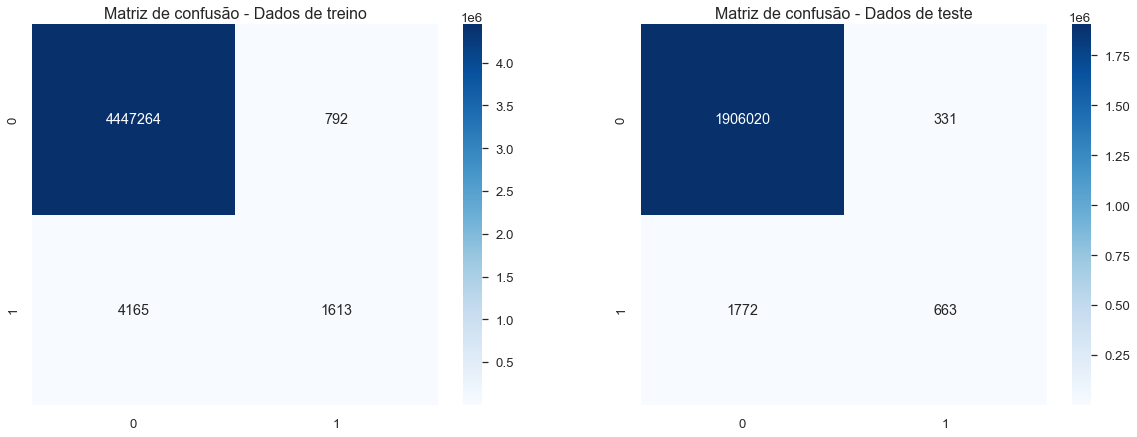

In [93]:
fig, ax = plt.subplots(1,2,figsize=(20,7)) # Grid de gráficos com 1 linha e 2 colunas

# Dados de treino
sns.heatmap(matriz_confusao_treino,cmap='Blues',annot=True,fmt='.0f',ax=ax[0])
ax[0].set_title('Matriz de confusão - Dados de treino',size=16)
# Dados de teste
sns.heatmap(matriz_confusao_teste,cmap='Blues',annot=True,fmt='.0f',ax=ax[1])
ax[1].set_title('Matriz de confusão - Dados de teste',size=16)
plt.show()

In [94]:
# Calculando precisão e recall com diferentes sumarizações
print('Acurácia: {:.2f}"'.format(accuracy_score(y_train,y_pred_train)))
print('Precisão: {:.2f}"'.format(precision_score(y_train,y_pred_train)))
print('recall: {:.2f}"'.format(recall_score(y_train,y_pred_train)))

Acurácia: 1.00"
Precisão: 0.67"
recall: 0.28"


In [95]:
#pip install -U yellowbrick

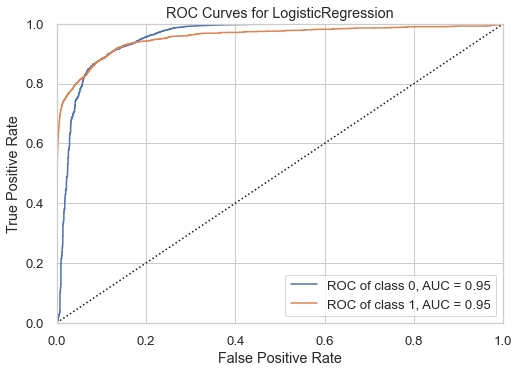

In [96]:
#Importando a biblioteca

from yellowbrick.classifier.rocauc import roc_auc

# Curvas ROC - Teste One vs. Rest
roc_auc(estimator=LR, # Modelo a ser treinado
    X_train=X_train_sc,y_train=y_train,
    X_test=X_test_sc,y_test=y_test,
    micro=False,macro=False, # Indicando que não queremos as curvas de micro e macro
    is_fitted=False # Indicando que o estimador já está treinado
)
plt.show()

In [97]:
#OBS este classificador levou mais de 30 minutos para rodar inviabilizando o negócio.
#Utilizando Support Vector Machine - SVM 
#SVM = LinearSVC()

In [98]:
#Treinando o modelo nos dados de treino
#SVM.fit(X_train_sc,y_train)

# Prevendo os resultados nos conjuntos de treino e de teste, usando o .predict()
#y_pred_train_svm = SVM.predict(X_train_sc)
#y_pred_test_svm = SVM.predict(X_test_sc)

# Verificando a base de predição de treino
#y_pred_train_svm

In [99]:
# Calculando a matriz de confusão para os dados de treino e teste
#matriz_confusao_treino_svm = confusion_matrix(y_train,y_pred_train_svm)
#matriz_confusao_teste_svm = confusion_matrix(y_test,y_pred_test_svm)

# Ilustrando o dataset
#matriz_confusao_treino_svm

In [100]:
#matriz_confusao_teste_svm

In [101]:
#ig, ax = plt.subplots(1,2,figsize=(20,7)) # Grid de gráficos com 1 linha e 2 colunas

# Dados de treino
#sns.heatmap(matriz_confusao_treino_svm,cmap='Blues',annot=True,fmt='.0f',ax=ax[0])
#ax[0].set_title('Matriz de confusão - Dados de treino',size=16)
# Dados de teste
#sns.heatmap(matriz_confusao_teste_svm,cmap='Blues',annot=True,fmt='.0f',ax=ax[1])
#ax[1].set_title('Matriz de confusão - Dados de teste',size=16)
#plt.show()

In [102]:
# Calculando precisão e recall com diferentes sumarizações
#print('Acurácia: {:.2f}"'.format(accuracy_score(y_train,y_pred_train_svm)))
#print('Precisão: {:.2f}"'.format(precision_score(y_train,y_pred_train_svm)))
#print('recall: {:.2f}"'.format(recall_score(y_train,y_pred_train_svm)))

In [104]:
# Curvas ROC - Teste One vs. Rest
#roc_auc(estimator=SVM, # Modelo a ser treinado
   # X_train=X_train_sc,y_train=y_train,
   # X_test=X_test_sc,y_test=y_test,
   # micro=False,macro=False, # Indicando que não queremos as curvas de micro e macro
   # is_fitted=False # Indicando que o estimador já está treinado
#)
#plt.show()

In [105]:
#Utilizandoo modelo Randomforest
rfc = RandomForestClassifier(n_jobs=4, 
                             random_state=2018,
                             criterion="gini",
                             n_estimators=100,
                             verbose=False)


In [106]:
rfc.fit(X_train_sc,y_train)

#Prevendo os resultados nos conjuntos de treino e de teste, usando o .predict()
y_pred_train_rfc = rfc.predict(X_train_sc)
y_pred_test_rfc = rfc.predict(X_test_sc)

# Verificando a base de predição de treino
y_pred_train_rfc

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [107]:
# 9 minutos de processamento.

In [108]:
#Calculando a matriz de confusão para os dados de treino e teste
matriz_confusao_treino_rfc = confusion_matrix(y_train,y_pred_train_rfc)
matriz_confusao_teste_rfc = confusion_matrix(y_test,y_pred_test_rfc)

# Ilustrando o dataset
matriz_confusao_treino_rfc

array([[4448056,       0],
       [      1,    5777]], dtype=int64)

In [109]:
matriz_confusao_teste_rfc

array([[1906291,      60],
       [    306,    2129]], dtype=int64)

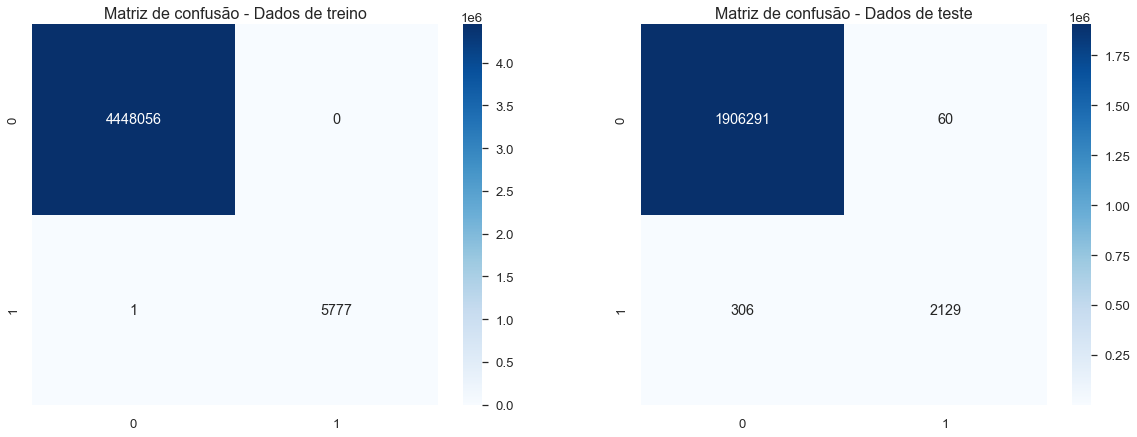

In [110]:
ig, ax = plt.subplots(1,2,figsize=(20,7)) # Grid de gráficos com 1 linha e 2 colunas

# Dados de treino
sns.heatmap(matriz_confusao_treino_rfc,cmap='Blues',annot=True,fmt='.0f',ax=ax[0])
ax[0].set_title('Matriz de confusão - Dados de treino',size=16)
# Dados de teste
sns.heatmap(matriz_confusao_teste_rfc,cmap='Blues',annot=True,fmt='.0f',ax=ax[1])
ax[1].set_title('Matriz de confusão - Dados de teste',size=16)
plt.show()

In [111]:
#Calculando precisão e recall com diferentes sumarizações
print('Acurácia: {:.2f}"'.format(accuracy_score(y_train,y_pred_train_rfc)))
print('Precisão: {:.2f}"'.format(precision_score(y_train,y_pred_train_rfc)))
print('recall: {:.2f}"'.format(recall_score(y_train,y_pred_train_rfc)))

Acurácia: 1.00"
Precisão: 1.00"
recall: 1.00"


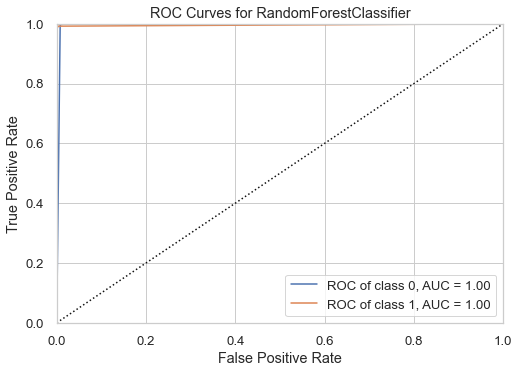

In [112]:
# Curvas ROC -
roc_auc(estimator=rfc, # Modelo a ser treinado
   X_train=X_train_sc,y_train=y_train,
   X_test=X_test_sc,y_test=y_test,
   micro=False,macro=False, # Indicando que não queremos as curvas de micro e macro
   is_fitted=False # Indicando que o estimador já está treinado
)
plt.show()

In [113]:
#Utilizando o modelo com o CGboost
xgb_reg = XGBClassifier(objective ='reg:logistic')

In [114]:
xgb_reg.fit(X_train_sc,y_train)

#Prevendo os resultados nos conjuntos de treino e de teste, usando o .predict()
y_pred_train_xgb = xgb_reg.predict(X_train_sc)
y_pred_test_xgb = xgb_reg.predict(X_test_sc)

# Verificando a base de predição de treino
y_pred_train_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [115]:
#Calculando a matriz de confusão para os dados de treino e teste
matriz_confusao_treino_xgb = confusion_matrix(y_train,y_pred_train_xgb)
matriz_confusao_teste_xgb = confusion_matrix(y_test,y_pred_test_xgb)

# Ilustrando o dataset
matriz_confusao_treino_xgb

array([[4448015,      41],
       [    100,    5678]], dtype=int64)

In [116]:
matriz_confusao_teste_xgb

array([[1906288,      63],
       [    169,    2266]], dtype=int64)

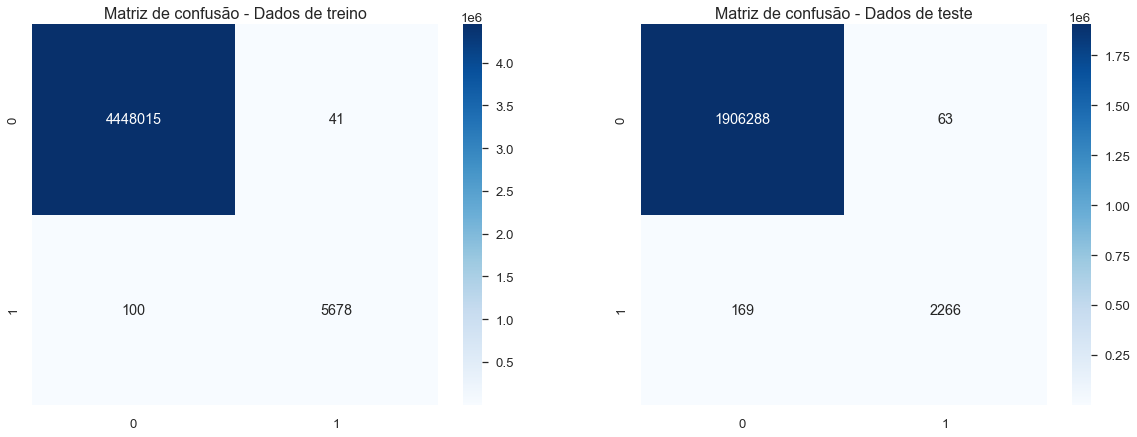

In [117]:
ig, ax = plt.subplots(1,2,figsize=(20,7)) # Grid de gráficos com 1 linha e 2 colunas

# Dados de treino
sns.heatmap(matriz_confusao_treino_xgb,cmap='Blues',annot=True,fmt='.0f',ax=ax[0])
ax[0].set_title('Matriz de confusão - Dados de treino',size=16)
# Dados de teste
sns.heatmap(matriz_confusao_teste_xgb,cmap='Blues',annot=True,fmt='.0f',ax=ax[1])
ax[1].set_title('Matriz de confusão - Dados de teste',size=16)
plt.show()

In [118]:
#Calculando precisão e recall com diferentes sumarizações
print('Acurácia: {:.2f}"'.format(accuracy_score(y_train,y_pred_train_xgb)))
print('Precisão: {:.2f}"'.format(precision_score(y_train,y_pred_train_xgb)))
print('recall: {:.2f}"'.format(recall_score(y_train,y_pred_train_xgb)))

Acurácia: 1.00"
Precisão: 0.99"
recall: 0.98"


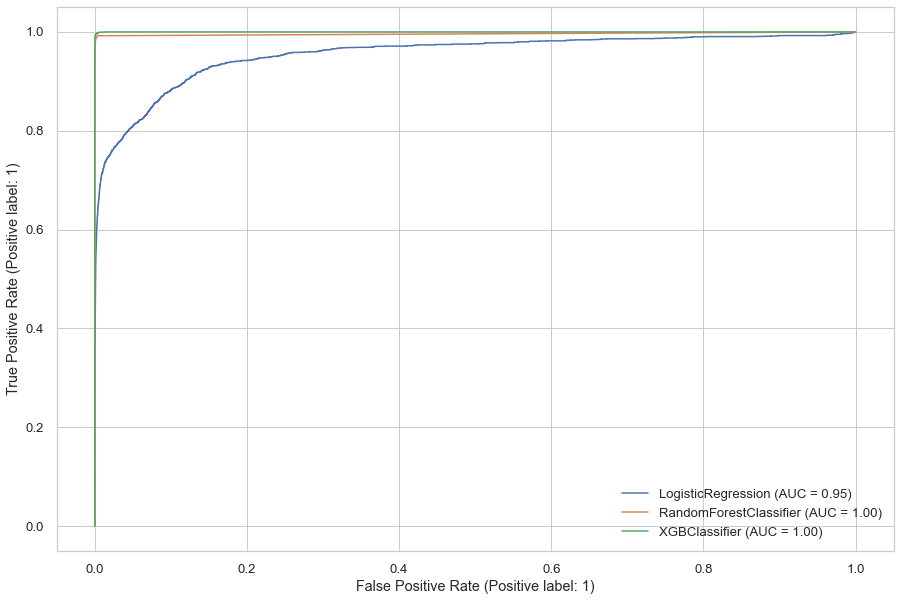

In [120]:
#Gerando todos os gráficos comparativo entre os modelos
classifiers = [LR, rfc, xgb_reg]
plt.figure(figsize=(15,10))
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test_sc, y_test, ax=ax)

In [122]:
#Plotando os resultados de todos os testes
df_aux = pd.DataFrame(columns = ['Classificador','Acuracia','Precisao','Recall', 'F1-Score'], index=range(len(classifiers)))
for i,value in enumerate(classifiers):
    y_pred = value.predict(X_test_sc)
    df_aux.iloc[i]['Classificador'] = type(value).__name__
    df_aux.iloc[i]['Acuracia'] = round(accuracy_score(y_test, y_pred), 4)
    df_aux.iloc[i]['Precisao'] = round(precision_score(y_test, y_pred), 4)
    df_aux.iloc[i]['Recall'] = round(recall_score(y_test, y_pred), 4)
    df_aux.iloc[i]['F1-Score'] = 2*(((precision_score(y_test, y_pred))*(recall_score(y_test, y_pred)))/\
                                    ((precision_score(y_test, y_pred))+(recall_score(y_test, y_pred))))

In [123]:
df_aux

,Classificador,Acuracia,Precisao,Recall,F1-Score
0,LogisticRegression,0.9989,0.667,0.2723,0.386702
1,RandomForestClassifier,0.9998,0.9726,0.8743,0.920848
2,XGBClassifier,0.9999,0.9729,0.9306,0.951301
